In [2]:
import numpy as np
import os
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, MaxPool2D, Concatenate, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from time import time

from tensorflow.keras.datasets import cifar10

Using TensorFlow backend.


In [3]:
def H(  inputs, num_filters , dropout_rate ):
    x = tf.keras.layers.BatchNormalization( epsilon=eps )( inputs )
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D((1, 1))(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False , kernel_initializer='he_normal' )(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate )(x)
    return x

In [4]:
def transition(inputs, num_filters , compression_factor , dropout_rate ):
    # compression_factor is the 'θ'
    x = tf.keras.layers.BatchNormalization( epsilon=eps )(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1] # The value of 'm'

    x = tf.keras.layers.Conv2D( np.floor( compression_factor * num_feature_maps ).astype( np.int ) ,
                               kernel_size=(1, 1), use_bias=False, padding='same' , kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

In [5]:
def dense_block( inputs, num_layers, num_filters, growth_rate , dropout_rate ):
    for i in range(num_layers): # num_layers is the value of 'l'
        conv_outputs = H(inputs, num_filters , dropout_rate )
        inputs = tf.keras.layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate # To increase the number of filters for each layer.
    return inputs, num_filters

In [6]:
input_shape = ( 32 , 32 , 3) 
num_blocks = 3
num_layers_per_block = 4
growth_rate = 16
dropout_rate = 0.4
compress_factor = 0.5
eps = 1.1e-5

num_filters = 16

inputs = tf.keras.layers.Input( shape=input_shape )
x = tf.keras.layers.Conv2D( num_filters , kernel_size=( 3 , 3 ) , use_bias=False, kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )( inputs )

for i in range( num_blocks ):
    x, num_filters = dense_block( x, num_layers_per_block , num_filters, growth_rate , dropout_rate )
    x = transition(x, num_filters , compress_factor , dropout_rate )

x = tf.keras.layers.GlobalAveragePooling2D()( x ) 
x = tf.keras.layers.Dense( 10 )( x ) # Num Classes for CIFAR-10
outputs = tf.keras.layers.Activation( 'softmax' )( x )

In [9]:
model = Model( inputs , outputs )
model.compile( loss=tf.keras.losses.sparse_categorical_crossentropy ,optimizer=tf.keras.optimizers.Adam( lr=0.0001 ) ,metrics=[ 'acc' ])
model.summary()
print(len(model.layers))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 30, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 30, 30, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

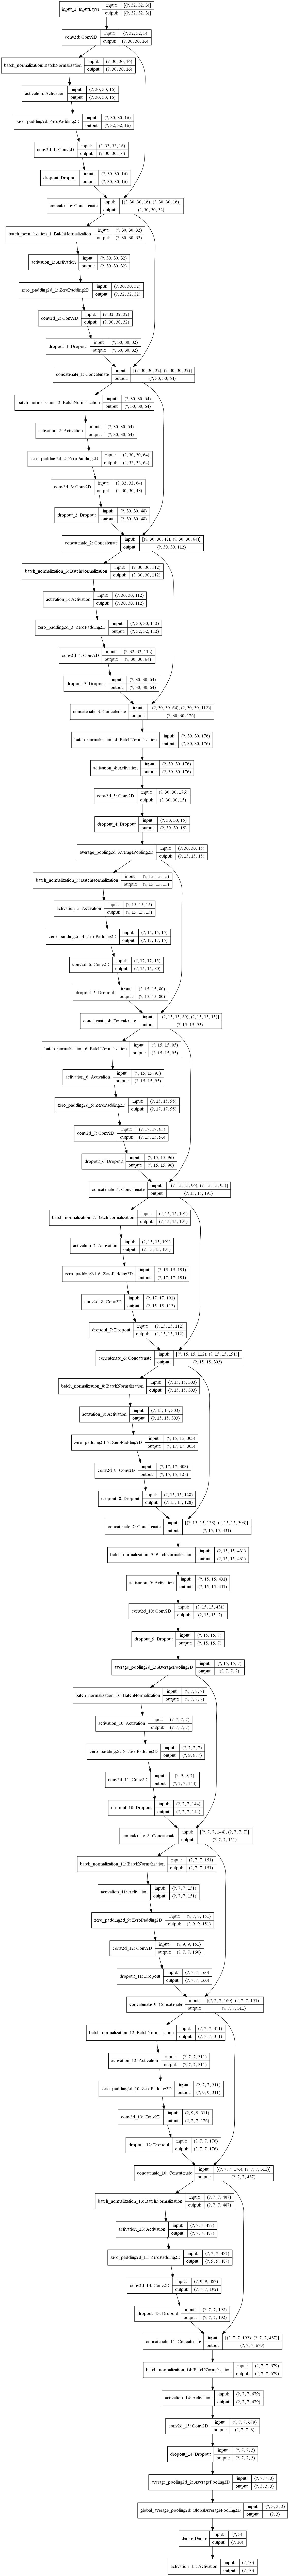

In [8]:
plot_model(model, show_shapes=True, to_file="densenet.png")

In [9]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# normalize to range 0-1
train_x = train_x / 255.0
test_x = test_x / 255.0

val_x = train_x[:5000]
val_y = train_y[:5000]

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1)
list_cb = [es]

In [13]:
start = time()
model.fit( train_x , train_y , epochs=50, batch_size=1024, validation_split=0.3, callbacks=list_cb)
training_time = time()-start

Train on 50000 samples, validate on 5000 samples
Epoch 1/50
50000/50000 [==============================] - 291s 6ms/sample - loss: 2.1132 - acc: 0.2312 - val_loss: 2.2994 - val_acc: 0.2094
Epoch 2/50
50000/50000 [==============================] - 233s 5ms/sample - loss: 1.9412 - acc: 0.3185 - val_loss: 2.1683 - val_acc: 0.2726
Epoch 3/50
50000/50000 [==============================] - 235s 5ms/sample - loss: 1.8088 - acc: 0.3822 - val_loss: 2.0583 - val_acc: 0.3846
Epoch 4/50
50000/50000 [==============================] - 249s 5ms/sample - loss: 1.6981 - acc: 0.4151 - val_loss: 1.8296 - val_acc: 0.4200
Epoch 5/50
50000/50000 [==============================] - 238s 5ms/sample - loss: 1.6115 - acc: 0.4418 - val_loss: 1.8963 - val_acc: 0.4082
Epoch 6/50
50000/50000 [==============================] - 240s 5ms/sample - loss: 1.5245 - acc: 0.4700 - val_loss: 1.7167 - val_acc: 0.4422
Epoch 7/50
50000/50000 [==============================] - 240s 5ms/sample - loss: 1.4501 - acc: 0.4965 - val_lo

In [14]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 12s 1ms/sample - loss: 1.2783 - acc: 0.7066


[1.2783328011989594, 0.7066]

In [ ]:
model.evaluate(train_x, train_y)

In [ ]:
training_time